In [16]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    14:41:42 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    14:41:42 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    14:41:42 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37885")
client

<Client: 'tcp://127.0.0.1:37885' processes=4 threads=16, memory=125.81 GiB>

In [5]:
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [6]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=1),2,3e8,4e8)


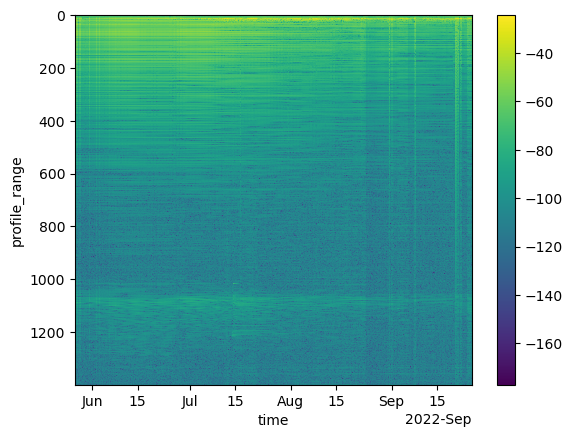

In [7]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()


Add fine range adjustment

In [27]:
phi = -np.angle(da_101_stacked).astype(float)
range_fine = phase2range(phi)
da_101_stacked['range_fine']=(['time','profile_range'],range_fine)
da_101_stacked['true_range'] = da_101_stacked.profile_range + da_101_stacked.range_fine

In [33]:
test = xa.dB(da_101_stacked.where(da_101_stacked.profile_range > 900)).argmax(dim='profile_range')

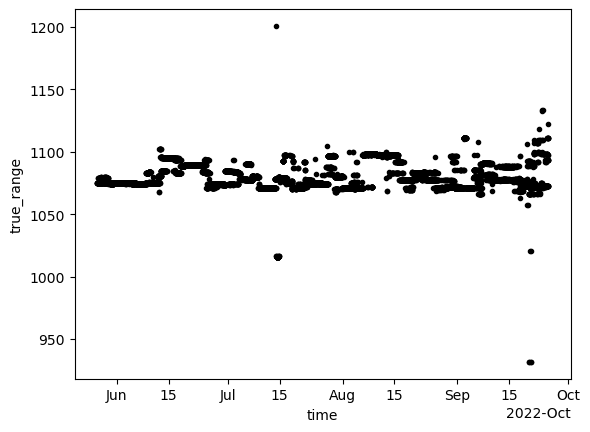

In [34]:
da_101_stacked.true_range.isel(profile_range=test).plot(linestyle='None',marker='.',color='k')

In [7]:
time_to_interp = pd.date_range("2022-06-01 00:00","2022-09-20 00:00", freq="15min")


In [8]:
profiles_interp = da_101_stacked.interp(time=time_to_interp,method='linear')

In [9]:
stack_profiles = profiles_interp.coarsen(time=96,boundary="pad").mean()

In [10]:
test = xa.dB(stack_profiles.where(stack_profiles.profile_range > 900)).argmax(dim='profile_range')

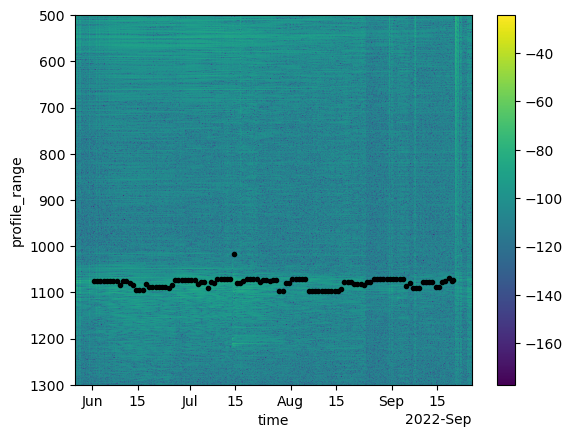

In [11]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()
plt.ylim([1300,500])
stack_profiles.profile_range.isel(profile_range=test).plot(linestyle='None',marker='.',color='k')

Try with winter

In [18]:
da_101_stacked = custom_stacked_profile_series(ds_101_w.chirp.isel(attenuator_setting_pair=0),2,2e8,4e8)

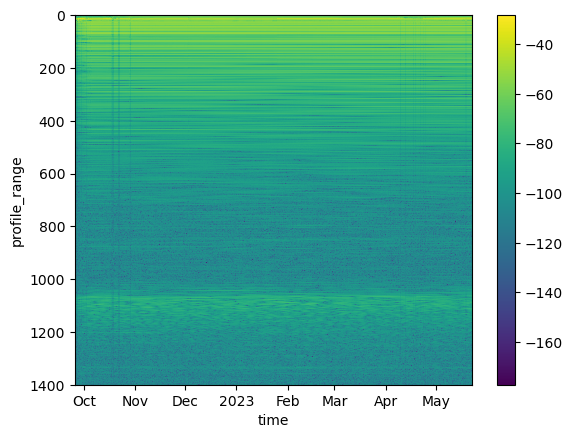

In [19]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()


In [20]:
time_to_interp = pd.date_range("2022-10-01 00:00","2023-05-01 00:00", freq="15min")


In [21]:
profiles_interp = da_101_stacked.interp(time=time_to_interp,method='linear')

In [23]:
stack_profiles = profiles_interp.coarsen(time=96,boundary="pad").mean()

In [24]:
test = xa.dB(stack_profiles.where(stack_profiles.profile_range > 900)).argmax(dim='profile_range')

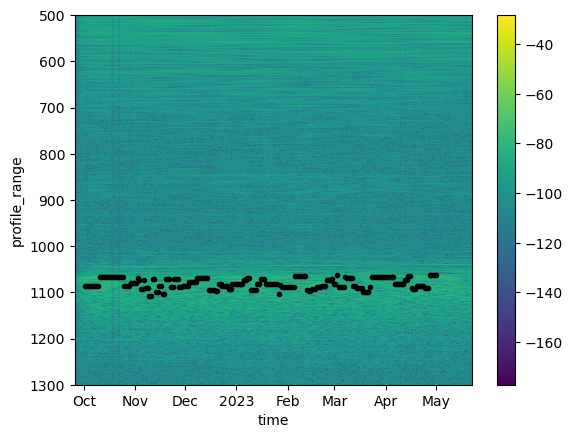

In [25]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()
plt.ylim([1300,500])
stack_profiles.profile_range.isel(profile_range=test).plot(linestyle='None',marker='.',color='k')

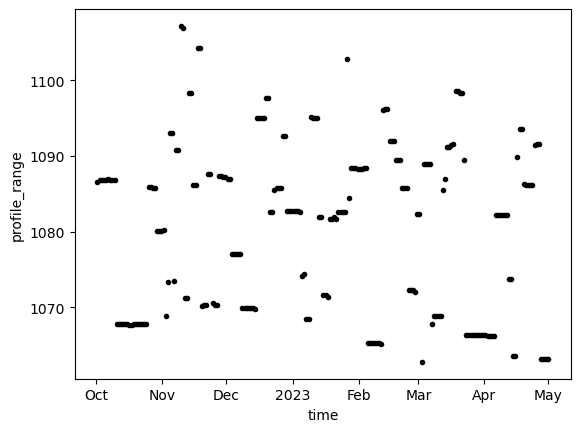

In [26]:
stack_profiles.profile_range.isel(profile_range=test).plot(linestyle='None',marker='.',color='k')